In [61]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName('linreg2').getOrCreate()
%matplotlib inline

In [2]:
# function imports
from pyspark.sql.functions import isnan,count,when
from pyspark.sql.functions import col as spark_col

In [3]:
data_path = '../data/cruise_ship_info.csv'
df_orig = spark.read.csv(data_path,inferSchema = True,header=True)
df_orig.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [4]:
print('Data Shape : ',(df_orig.count(),len(df_orig.columns))) # get shape 
data = df_orig.select('*') # create copy of data

Data Shape :  (158, 9)


In [5]:
for i in range(5):
    print(data.head(5)[i].asDict()) # data example

{'Ship_name': 'Journey', 'Cruise_line': 'Azamara', 'Age': 6, 'Tonnage': 30.276999999999997, 'passengers': 6.94, 'length': 5.94, 'cabins': 3.55, 'passenger_density': 42.64, 'crew': 3.55}
{'Ship_name': 'Quest', 'Cruise_line': 'Azamara', 'Age': 6, 'Tonnage': 30.276999999999997, 'passengers': 6.94, 'length': 5.94, 'cabins': 3.55, 'passenger_density': 42.64, 'crew': 3.55}
{'Ship_name': 'Celebration', 'Cruise_line': 'Carnival', 'Age': 26, 'Tonnage': 47.262, 'passengers': 14.86, 'length': 7.22, 'cabins': 7.43, 'passenger_density': 31.8, 'crew': 6.7}
{'Ship_name': 'Conquest', 'Cruise_line': 'Carnival', 'Age': 11, 'Tonnage': 110.0, 'passengers': 29.74, 'length': 9.53, 'cabins': 14.88, 'passenger_density': 36.99, 'crew': 19.1}
{'Ship_name': 'Destiny', 'Cruise_line': 'Carnival', 'Age': 17, 'Tonnage': 101.353, 'passengers': 26.42, 'length': 8.92, 'cabins': 13.21, 'passenger_density': 38.36, 'crew': 10.0}


In [6]:
###  check for null values

# Method 1

# def get_null_count(data,col):
#     return (data.count() - data.select(col).na.drop(how="any").count())

# for col in data.columns:
#     print('{} : {}'.format(col,get_null_count(data,col)))

# Method 2


data.select([count(when( isnan(c) | spark_col(c).isNull(),c)).alias(c) for c in data.columns]).show()

+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|        0|          0|  0|      0|         0|     0|     0|                0|   0|
+---------+-----------+---+-------+----------+------+------+-----------------+----+



In [7]:
# check unique values in ship_name
print(data.select('Ship_name').distinct().count())

138


In [8]:
data = data.select(['Cruise_line', 'Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density', 'crew'])

In [27]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

In [12]:
data.select('Cruise_line').distinct().show()
print(data.select('Cruise_line').distinct().count())

+-----------------+
|      Cruise_line|
+-----------------+
|            Costa|
|              P&O|
|           Cunard|
|Regent_Seven_Seas|
|              MSC|
|         Carnival|
|          Crystal|
|           Orient|
|         Princess|
|        Silversea|
|         Seabourn|
| Holland_American|
|         Windstar|
|           Disney|
|        Norwegian|
|          Oceania|
|          Azamara|
|        Celebrity|
|             Star|
|  Royal_Caribbean|
+-----------------+

20


In [14]:
cont_cols = ['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density']
cate_cols = ['Cruise_line']
output_col = 'crew'

In [24]:
## creating correlation plot
temp_arr = np.zeros((len(cont_cols)+1,len(cont_cols)+1))
temp_list = cont_cols + [output_col]
for i,col1 in enumerate(temp_list):
    for j,col2 in enumerate(temp_list):
        temp_arr[i,j] = data.corr(col1,col2)
    
# temp_arr
cor_df = pd.DataFrame(temp_arr,columns = temp_list,index = temp_list)
cor_df

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
Age,1.000000,-0.606646,-0.515542,-0.532286,-0.510019,-0.278830,-0.530657
Tonnage,-0.606646,1.000000,0.945061,0.922368,0.948764,-0.040846,0.927569
passengers,-0.515542,0.945061,1.000000,0.883535,0.976341,-0.294867,0.915234
length,-0.532286,0.922368,0.883535,1.000000,0.889798,-0.090488,0.895857
cabins,-0.510019,0.948764,0.976341,0.889798,1.000000,-0.253181,0.950823
passenger_density,-0.278830,-0.040846,-0.294867,-0.090488,-0.253181,1.000000,-0.155509
crew,-0.530657,0.927569,0.915234,0.895857,0.950823,-0.155509,1.000000


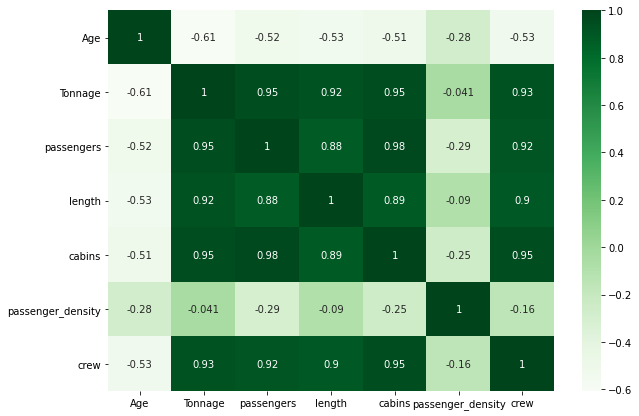

In [26]:
fig = plt.figure(figsize = (10,7))
sns.heatmap(cor_df,annot = True,cmap = 'Greens')

In [29]:
## checking correlation for the categorical variable
string_index = StringIndexer(inputCol='Cruise_line',outputCol='Cruise_line_indexed')
string_index = string_index.fit(data)
temp = string_index.transform(data)

In [33]:
temp.select('Cruise_line_indexed').distinct().orderBy('Cruise_line_indexed').show()

+-------------------+
|Cruise_line_indexed|
+-------------------+
|                0.0|
|                1.0|
|                2.0|
|                3.0|
|                4.0|
|                5.0|
|                6.0|
|                7.0|
|                8.0|
|                9.0|
|               10.0|
|               11.0|
|               12.0|
|               13.0|
|               14.0|
|               15.0|
|               16.0|
|               17.0|
|               18.0|
|               19.0|
+-------------------+



In [36]:
## Using oneHotEncoder 
ohe = OneHotEncoder(inputCol='Cruise_line_indexed',outputCol='Cruise_line_hot')
ohe = ohe.fit(temp)
temp_one = ohe.transform(temp)
temp_one.show()

+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+---------------+
|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_indexed|Cruise_line_hot|
+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+---------------+
|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|               16.0|(19,[16],[1.0])|
|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|               16.0|(19,[16],[1.0])|
|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|                1.0| (19,[1],[1.0])|
|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|                1.0| (19,[1],[1.0])|
|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|                1.0| (19,[1],[1.0])|
|   Carnival| 22|            70.

In [48]:
one_hot_array = np.zeros((data.count(),temp_one.select('Cruise_line_hot').head()[0].toArray().shape[0]))
print(one_hot_array.shape)

(158, 19)


In [51]:
for i,row in enumerate(temp_one.select('Cruise_line_hot').collect()):
    one_hot_array[i] = row[0].toArray()

In [52]:
one_hot_df = pd.DataFrame(one_hot_array,columns = data)

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
one_cols = [row[0] for row in temp_one.select('Cruise_line').distinct().collect()]
print(one_cols)

['Costa', 'P&O', 'Cunard', 'Regent_Seven_Seas', 'MSC', 'Carnival', 'Crystal', 'Orient', 'Princess', 'Silversea', 'Seabourn', 'Holland_American', 'Windstar', 'Disney', 'Norwegian', 'Oceania', 'Azamara', 'Celebrity', 'Star', 'Royal_Caribbean']


In [59]:
one_df = pd.DataFrame(one_hot_array,columns = one_cols[:-1])
one_df['crew'] = [row[0] for row in data.select('crew').collect()]
one_df

,Costa,P&O,Cunard,Regent_Seven_Seas,MSC,Carnival,Crystal,Orient,Princess,Silversea,Seabourn,Holland_American,Windstar,Disney,Norwegian,Oceania,Azamara,Celebrity,Star,crew
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.55
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.55
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.70
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.10
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.59
154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.00
155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.88
156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.88


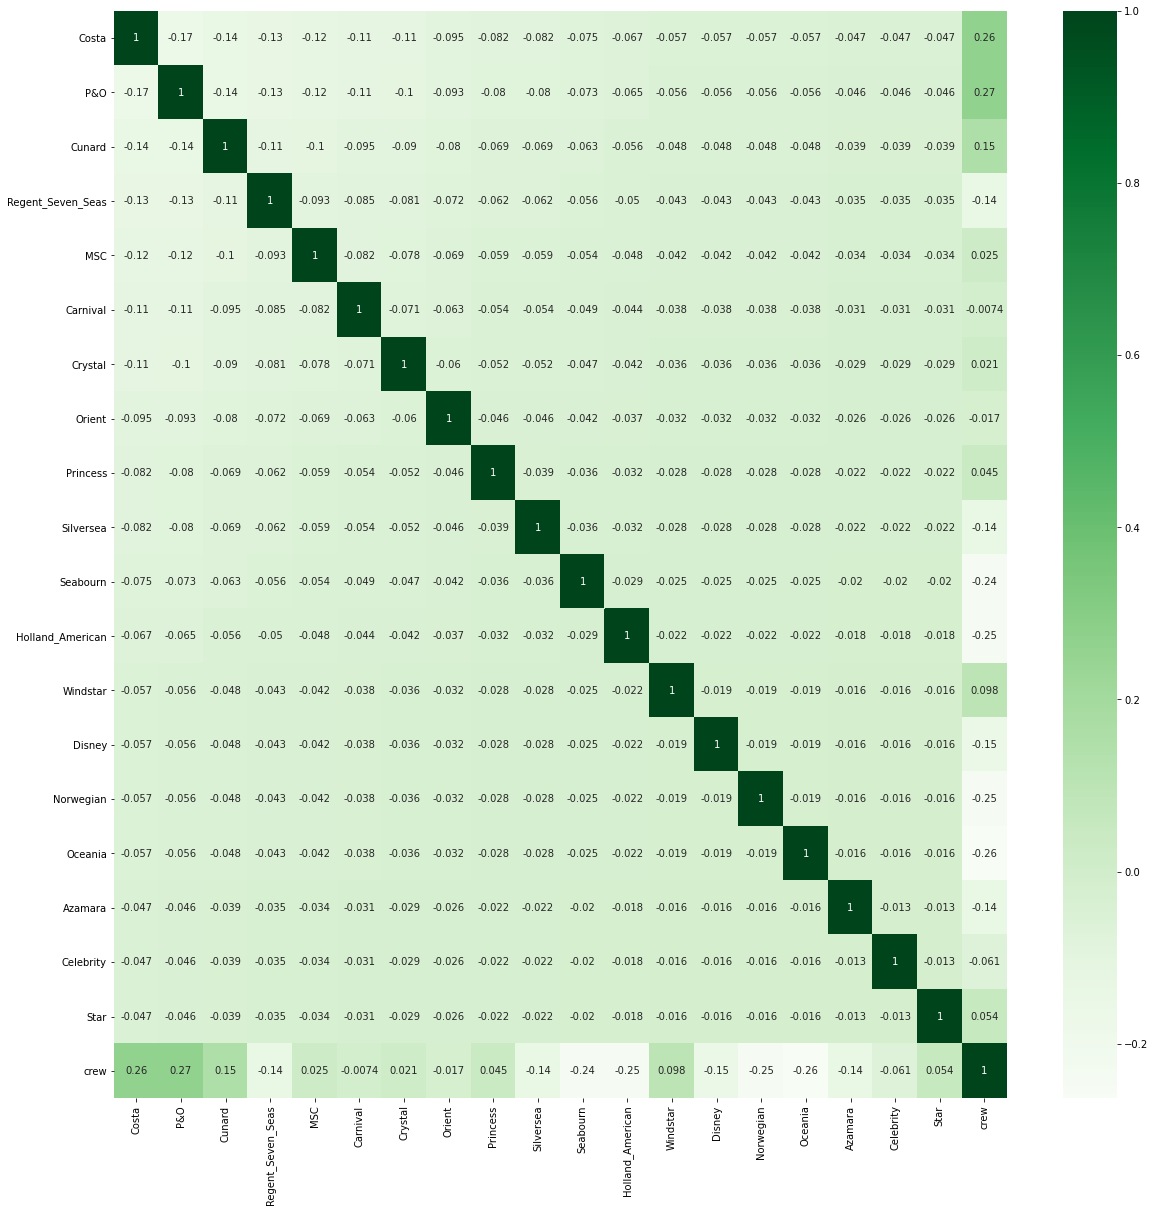

In [60]:
plt.figure(figsize = (20,20))
sns.heatmap(one_df.corr(),annot = True,cmap = 'Greens')

In [62]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [63]:
temp_one.show()

+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+---------------+
|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_indexed|Cruise_line_hot|
+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+---------------+
|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|               16.0|(19,[16],[1.0])|
|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|               16.0|(19,[16],[1.0])|
|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|                1.0| (19,[1],[1.0])|
|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|                1.0| (19,[1],[1.0])|
|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|                1.0| (19,[1],[1.0])|
|   Carnival| 22|            70.

In [65]:
assembler = VectorAssembler(inputCols=['Age','Tonnage','passengers','length','cabins','passenger_density',
                                       'Cruise_line_hot'],outputCol='features')
output = assembler.transform(temp_one)
output.limit(1).show()

+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+---------------+--------------------+
|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_indexed|Cruise_line_hot|            features|
+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+---------------+--------------------+
|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|               16.0|(19,[16],[1.0])|(25,[0,1,2,3,4,5,...|
+-----------+---+------------------+----------+------+------+-----------------+----+-------------------+---------------+--------------------+



In [67]:
all_data = output.select(['features','crew'])
train,test = all_data.randomSplit([0.8,0.2])
train.count(),test.count()

(131, 27)

In [68]:
lr = LinearRegression(featuresCol='features',labelCol='crew',predictionCol='preds')
print(lr)

LinearRegression_748d86a90ad7


In [69]:
lr_model = lr.fit(train)

In [75]:
# print('Coefficients : ',lr_model.coefficients)
# print('Intercept : ',lr_model.intercept)
summary = lr_model.summary
print('Training summary : ')
print('R^2 : ',summary.r2)
print('RMSE : ',summary.rootMeanSquaredError)

Training summary : 
R^2 :  0.9403105974191561
RMSE :  0.8385686660557783


In [76]:
test_res = lr_model.evaluate(test)

In [84]:
test_res.residuals.show()
print('Test summary')
print('RMSE : ',test_res.rootMeanSquaredError)
print('R2 : ',test_res.r2)

+--------------------+
|           residuals|
+--------------------+
|  0.3392473903193025|
| 0.07836367431971158|
| 0.17099359673097148|
| -1.5971809151652199|
| 0.06008484771482081|
| 0.21672707996943252|
|   -0.53274931646457|
| -0.9549759149284904|
|  0.4996855827248039|
|  0.5244345575610074|
| 0.12729069082026356|
|  0.5450676323556465|
| -0.3747898867811408|
|-0.16027733463003824|
|  0.2698461951692064|
|  1.0199440036632215|
| -1.2950225937266522|
| -0.3684634791160546|
|   1.372065122669048|
|-0.21802851845097493|
+--------------------+
only showing top 20 rows

Test summary
RMSE :  0.6778437670558523
R2 :  0.9561997668340348


In [83]:
all_data.describe().show()

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              158|
|   mean|7.794177215189873|
| stddev|3.503486564627034|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



In [88]:
preds = lr_model.transform(test.select('features'))
preds.show()

+--------------------+------------------+
|            features|             preds|
+--------------------+------------------+
|(25,[0,1,2,3,4,5,...| 8.240752609680698|
|(25,[0,1,2,3,4,5,...| 7.121636325680289|
|(25,[0,1,2,3,4,5,...| 10.12900640326903|
|(25,[0,1,2,3,4,5,...| 10.89718091516522|
|(25,[0,1,2,3,4,5,...| 9.139915152285178|
|(25,[0,1,2,3,4,5,...| 8.783272920030567|
|(25,[0,1,2,3,4,5,...|  5.73274931646457|
|(25,[0,1,2,3,4,5,...|  6.26497591492849|
|(25,[0,1,2,3,4,5,...| 5.380314417275196|
|(25,[0,1,2,3,4,5,...|5.3555654424389925|
|(25,[0,1,2,3,4,5,...|10.962709309179736|
|(25,[0,1,2,3,4,5,...|10.454932367644354|
|(25,[0,1,2,3,4,5,...|11.274789886781141|
|(25,[0,1,2,3,4,5,...|0.7602773346300382|
|(25,[0,1,2,3,4,5,...| 7.130153804830794|
|(25,[0,1,2,3,4,5,...| 4.330055996336778|
|(25,[0,1,2,3,4,5,...| 8.095022593726652|
|(25,[0,1,2,3,4,5,...| 5.068463479116055|
|(25,[0,1,2,3,4,5,...| 3.097934877330952|
|(25,[0,1,2,3,4,5,...| 2.328028518450975|
+--------------------+------------

In [89]:
test.show()

+--------------------+-----+
|            features| crew|
+--------------------+-----+
|(25,[0,1,2,3,4,5,...| 8.58|
|(25,[0,1,2,3,4,5,...|  7.2|
|(25,[0,1,2,3,4,5,...| 10.3|
|(25,[0,1,2,3,4,5,...|  9.3|
|(25,[0,1,2,3,4,5,...|  9.2|
|(25,[0,1,2,3,4,5,...|  9.0|
|(25,[0,1,2,3,4,5,...|  5.2|
|(25,[0,1,2,3,4,5,...| 5.31|
|(25,[0,1,2,3,4,5,...| 5.88|
|(25,[0,1,2,3,4,5,...| 5.88|
|(25,[0,1,2,3,4,5,...|11.09|
|(25,[0,1,2,3,4,5,...| 11.0|
|(25,[0,1,2,3,4,5,...| 10.9|
|(25,[0,1,2,3,4,5,...|  0.6|
|(25,[0,1,2,3,4,5,...|  7.4|
|(25,[0,1,2,3,4,5,...| 5.35|
|(25,[0,1,2,3,4,5,...|  6.8|
|(25,[0,1,2,3,4,5,...|  4.7|
|(25,[0,1,2,3,4,5,...| 4.47|
|(25,[0,1,2,3,4,5,...| 2.11|
+--------------------+-----+
only showing top 20 rows

